In [ ]:
import pandas as pd
import os
import sys
import yaml
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
# Get the current working directory
current_dir = os.getcwd() 

# Calculate the parent directory (or the project root)
project_root = os.path.dirname(current_dir)

# Append it to sys.path
sys.path.append(project_root)

In [57]:
print("Project root added to sys.path:", project_root)

Project root added to sys.path: c:\Users\Besitzer\OneDrive\Dokumente\CBS_Copenhagen\Semester\WS2025\AdvCV\Final Exam\CV_Test


In [58]:
# Define the paths relative to the project root
relative_head_path = r"data\Head\misclassifications_head.json"
relative_neckHead_path = r"data\NeckHead\misclassifications_neckHead.json"
relative_entireModel_path = r"data\EntireModel\misclassifications_entireModel.json"
relative_classes_path = r"PlayingCardDetection-1\data.yaml"

# Join the project root with the relative paths to get the correct absolute paths
head_path = os.path.join(project_root, relative_head_path)
neckHead_path = os.path.join(project_root, relative_neckHead_path)
entireModel_path = os.path.join(project_root, relative_entireModel_path)
classes_path = os.path.join(project_root, relative_classes_path)

In [59]:
misclassifications_head = pd.read_json(head_path, orient='split')
misclassifications_neckHead = pd.read_json(neckHead_path, orient='split')
misclassifications_entireModel = pd.read_json(entireModel_path, orient='split')

In [60]:
# 1. Read the YAML file
with open(classes_path, 'r') as f:
    yaml_data = yaml.safe_load(f)

# Extract the names and create a mapping
names = yaml_data['names']

# Create the DataFrame with class IDs (0-51 for cards, 52 for background)
df_class_map = pd.DataFrame({
    'class_id': list(range(len(names))) + [52],
    'class_name': names + ['background']
})

In [61]:
# join the misclassification data with the class names for true class
misclassifications_head = misclassifications_head.merge(df_class_map, left_on='True_Class_Index', right_on='class_id', how='left').drop(columns=['class_id'])
# change column name
misclassifications_head = misclassifications_head.rename(columns={'class_name': 'True_ClassName'})

# join the misclassification data with the class names for predicted class
misclassifications_head = misclassifications_head.merge(df_class_map, left_on='Predicted_Class_Index', right_on='class_id', how='left').drop(columns=['class_id'])
# change column name
misclassifications_head = misclassifications_head.rename(columns={'class_name': 'Predicted_ClassName'})

# drop columns
misclassifications_head = misclassifications_head.drop(columns=['True_Class_Index', 'Predicted_Class_Index','Is_Correct', 'True_Class_Name', 'Predicted_Class_Name'])

In [62]:
# join the misclassification data with the class names for true class
misclassifications_neckHead = misclassifications_neckHead.merge(df_class_map, left_on='True_Class_Index', right_on='class_id', how='left').drop(columns=['class_id'])
# change column name
misclassifications_neckHead = misclassifications_neckHead.rename(columns={'class_name': 'True_ClassName'})

# join the misclassification data with the class names for predicted class
misclassifications_neckHead = misclassifications_neckHead.merge(df_class_map, left_on='Predicted_Class_Index', right_on='class_id', how='left').drop(columns=['class_id'])
# change column name
misclassifications_neckHead = misclassifications_neckHead.rename(columns={'class_name': 'Predicted_ClassName'})

# drop columns
misclassifications_neckHead = misclassifications_neckHead.drop(columns=['True_Class_Index', 'Predicted_Class_Index','Is_Correct', 'True_Class_Name', 'Predicted_Class_Name'])

In [63]:
# join the misclassification data with the class names for true class
misclassifications_entireModel = misclassifications_entireModel.merge(df_class_map, left_on='True_Class_Index', right_on='class_id', how='left').drop(columns=['class_id'])
# change column name
misclassifications_entireModel = misclassifications_entireModel.rename(columns={'class_name': 'True_ClassName'})

# join the misclassification data with the class names for predicted class
misclassifications_entireModel = misclassifications_entireModel.merge(df_class_map, left_on='Predicted_Class_Index', right_on='class_id', how='left').drop(columns=['class_id'])
# change column name
misclassifications_entireModel = misclassifications_entireModel.rename(columns={'class_name': 'Predicted_ClassName'})

# drop columns
misclassifications_entireModel = misclassifications_entireModel.drop(columns=['True_Class_Index', 'Predicted_Class_Index','Is_Correct', 'True_Class_Name', 'Predicted_Class_Name'])

In [64]:
# count background misclassifications for true and predicted classes
background_true_count = misclassifications_head[misclassifications_head['True_ClassName'] == 'background']['Count'].sum()
background_predicted_count = misclassifications_head[misclassifications_head['Predicted_ClassName'] == 'background']['Count'].sum() 
print(f"Background as TRUE class misclassifications (Head Model): {background_true_count}")
print(f"Background as PREDICTED class misclassifications (Head Model): {background_predicted_count}")

Background as TRUE class misclassifications (Head Model): 31
Background as PREDICTED class misclassifications (Head Model): 3406


Background as TRUE: The model predicted a card where no card was present.

Background as PREDICTED: The model missed a card where one should have been detected.

In [65]:
methods = {
    'Head Model': misclassifications_head,
    'NeckHead Model': misclassifications_neckHead,
    'Entire Model': misclassifications_entireModel
}

In [66]:
def get_error_data(df):
    """Returns the total error count and the top confusion pattern for the worst class."""
    
    # 1. Calculate Total Misclassifications
    df_errors = df[df['Error_Type'] == 'Misclassification']
    total_errors = df_errors['Count'].sum()
    
    # 2. Identify the Worst Struggling Class
    struggling_true_classes = df_errors.groupby('True_ClassName')['Count'].sum().sort_values(ascending=False)
    
    if struggling_true_classes.empty:
        return total_errors, None

    worst_class_name = struggling_true_classes.index[0] 
    
    # 3. Get the Confusion Pattern for the Worst Class
    worst_class_df = df_errors[df_errors['True_ClassName'] == worst_class_name]
    confusion_pattern = worst_class_df.groupby('Predicted_ClassName')['Count'].sum().sort_values(ascending=False).head(5)
    confusion_pattern.name = worst_class_name # Rename series to the class name for clarity
    
    return total_errors, confusion_pattern

C:\Users\Besitzer\AppData\Local\Temp\ipykernel_16624\1572695157.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Total Errors', data=df_total_errors, palette='viridis')


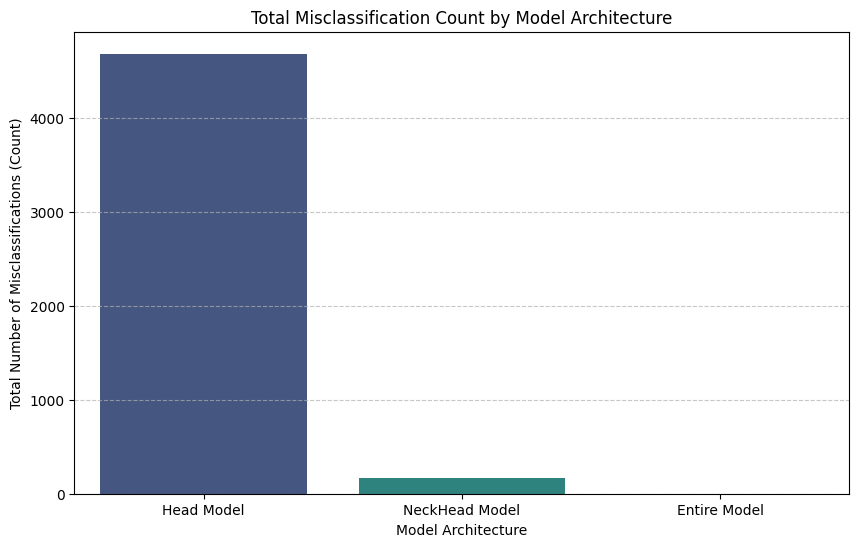

In [67]:
# --- Main Plotting Script ---

# 1. Pre-process and collect data for plotting
total_errors = {}
confusion_data = {} # Will hold the top 5 confusion patterns for the worst class of each model

for name, df in methods.items():
    errors, confusion_pattern = get_error_data(df)
    total_errors[name] = errors
    if confusion_pattern is not None:
        confusion_data[name] = confusion_pattern

# Convert collected data into DataFrames for easy plotting
df_total_errors = pd.Series(total_errors).sort_values(ascending=False).reset_index()
df_total_errors.columns = ['Model', 'Total Errors']

# Combine all confusion patterns into a single DataFrame for the stacked plot
if confusion_data:
    df_confusion_combined = pd.DataFrame(confusion_data).fillna(0)
    # The index will be the Predicted_ClassName
    df_confusion_combined.index.name = 'Predicted_ClassName'
    df_confusion_combined = df_confusion_combined.reset_index()
    
# --- Plot 1: Total Misclassifications by Model ---
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Total Errors', data=df_total_errors, palette='viridis')
plt.title('Total Misclassification Count by Model Architecture')
plt.xlabel('Model Architecture')
plt.ylabel('Total Number of Misclassifications (Count)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

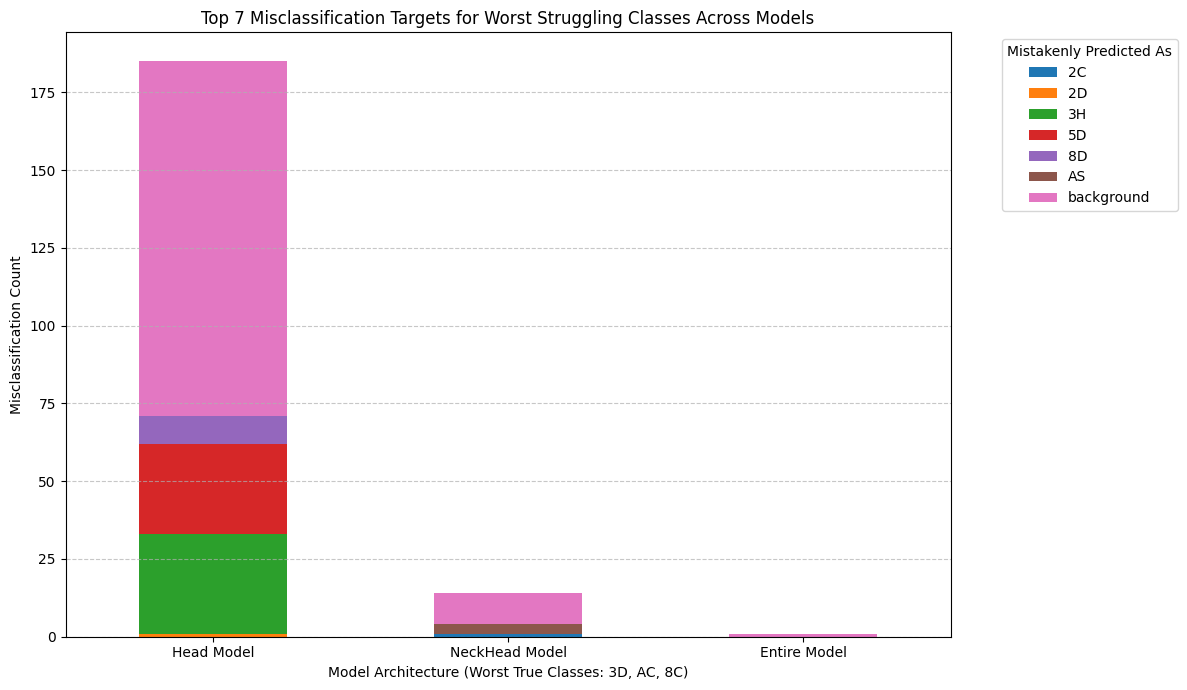

In [68]:
# --- Plot 2: Top Confusion Patterns for the Worst Struggling Class ---
if confusion_data:
    # Set the Predicted_ClassName as the index
    plot_df = df_confusion_combined.set_index('Predicted_ClassName')
    
    # Check if there's any data remaining after filtering
    if not plot_df.empty:
        plot_df.T.plot(kind='bar', stacked=True, figsize=(12, 7))
        
        # Get the names of the worst classes for the title
        worst_classes = [s.name for s in confusion_data.values()]
        
        plt.title(f'Top 7 Misclassification Targets for Worst Struggling Classes Across Models')
        plt.xlabel(f'Model Architecture (Worst True Classes: {", ".join(worst_classes)})')
        plt.ylabel('Misclassification Count')
        plt.xticks(rotation=0)
        plt.legend(title='Mistakenly Predicted As', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print("\nCould not generate the Confusion Plot as the combined confusion data is empty.")
else:
    print("\nCould not generate the Confusion Plot as no confusion data was returned.")

- Background means model has missed a card where should have been one
- Neck + Head & Entire are pretty confident --> manly missing cards not predicting falsly
- Head only also missclassfies a lot of cards

In [69]:
# most misclassified combinations
for name, df in methods.items():
    print(f"\nMost Misclassified Combinations for {name}:")
    misclassified_combinations = df[df['Error_Type'] == 'Misclassification']
    top_combinations = misclassified_combinations.sort_values(by='Count', ascending=False).head(10)
    print(top_combinations[['True_ClassName', 'Predicted_ClassName', 'Count']])


Most Misclassified Combinations for Head Model:
   True_ClassName Predicted_ClassName  Count
40             3S          background    120
44             3D          background    114
52             8S          background    104
55             5D          background     98
56             8C          background     98
54             5S          background     98
57             6S          background     91
59             6C          background     88
58             KD          background     88
61             8D          background     83

Most Misclassified Combinations for NeckHead Model:
   True_ClassName Predicted_ClassName  Count
52             AC          background     10
53             AS          background      9
54             3S          background      8
55             2C                  2S      7
56             2S          background      6
57             QH          background      6
58             2H          background      5
59             3D          background      

In [70]:
for name, df in methods.items():
    print(f"\n{'='*50}")
    print(f"Top 10 Card-to-Card Misclassifications for {name}:")
    print(f"{'='*50}")

    # 1. Filter for all misclassifications
    misclassified_combinations = df[df['Error_Type'] == 'Misclassification']
    
    # 2. FILTER OUT Background (Index 52) from TRUE Class
    # (Removes False Positives: Background -> Card)
    df_filtered = misclassified_combinations[
        misclassified_combinations['True_ClassName'] != 'background'
    ]
    
    # 3. FILTER OUT Background (Index 52) from PREDICTED Class
    # (Removes False Negatives: Card -> Background)
    df_filtered = df_filtered[
        df_filtered['Predicted_ClassName'] != 'background'
    ]

    # 4. Sort and display the top 10 remaining pure classification errors
    top_combinations = df_filtered.sort_values(by='Count', ascending=False).head(10)
    
    print(top_combinations[['True_ClassName', 'Predicted_ClassName', 'Count']])


Top 10 Card-to-Card Misclassifications for Head Model:
    True_ClassName Predicted_ClassName  Count
101             3D                  3H     32
104             3D                  5D     29
105             KD                  KH     24
107             KS                  KC     23
106             2D                  2H     23
109             3S                  5S     20
110             3S                  3C     19
112             6S                  8S     18
111             QH                  QD     18
114             AS                  AC     17

Top 10 Card-to-Card Misclassifications for NeckHead Model:
   True_ClassName Predicted_ClassName  Count
55             2C                  2S      7
64             AD                  AH      4
69             2D                  2H      3
70             AC                  AS      3
77             QD                  QH      2
78             AS                  4S      2
83             3C                  3S      2
88             2S 